**GAN based random text generator**

GAN is well known for it's non-discrete data generation abilities.<br>
In this notebook I'll adapt and train GAN for text generation. 

First, let's create data loader with tokenizer.

In [ ]:
import re
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


class DataLoader:

    def __init__(self, src_csv="", src_column='', sentence_len=100, num_words=10000, max_dataset_size=50000):
        self.__src_csv = src_csv  # source csv file with test data
        self.__src_column = src_column # column name in source file
        self.__sentence_len = sentence_len  # max sentence length
        self.__num_words = num_words  # number of most frequent words to keep
        self.__max_dataset_size = max_dataset_size
        self.__tokenizer = None # tokenizer
        self.sentences = []  # text data
        self.sequences = np.array([])  # indexed data from tokenizer

    def __load_file(self):
        df = pd.read_csv(self.__src_csv, keep_default_na=False) 
        self.sentences = [re.sub(r"<.*?>", " ", x) for x in df['review']]  # remove html tags

        i = 0
        prevLen = -1
        temp = []
        while len(temp) != prevLen and len(temp) < self.__max_dataset_size: # split sentences
          prevLen = len(temp)
          temp += [s.split('.')[i].strip() for s in self.sentences if len(s.split('.')) > i and len(s.split('.')[i].strip()) > 0]
          i += 1
        self.sentences = temp
        self.sentences = self.sentences[:self.__max_dataset_size]
        # rest of data cleaning is done by tokenizer

    def __init_tokenizer(self):
        # Tokenization
        # splitted by space
        # filters = default - period sign
        # unknown word set to <OOV>
        # lower case
        # saves only __num_words most frequent words
        self.tokenizer = Tokenizer(num_words=self.__num_words, lower=True, split=' ', oov_token='<OOV>', filters='!"#$%&()*+,-/:.;<=>?@[\\]^_`{|}~\t\n')
        self.tokenizer.fit_on_texts(self.sentences) # fit on text data
        
    def __init_sequences(self):
        if self.sequences.size < 1:
            self.__load_file()
            self.__init_tokenizer()
            self.sequences = self.tokenizer.texts_to_sequences(self.sentences) # text to tokenizer indexes
            self.sequences = pad_sequences(self.sequences, maxlen=self.__sentence_len, dtype='float32', padding='post') # padding 
            

    def get(self):
        self.__init_sequences()
        return self.sequences

Define all parameters and paths.

In [ ]:
SOURCE_FILE = "drive/MyDrive/Colab Notebooks/IMDB Dataset.csv" # test data file path (here IMDB reviews)
AE_MODEL_PATH="drive/MyDrive/Colab Notebooks/text-generator/AEmodel_lstm_4500_cce_dd_4" # autoencoder path
GAN_MODEL_PATH="drive/MyDrive/Colab Notebooks/text-generator/GANsma_4"
PLOT_PATH="drive/MyDrive/Colab Notebooks/text-generator/plots/{}4.png" # plots path
HISTORY_PATH="drive/MyDrive/Colab Notebooks/text-generator/history/{}4.csv" # learning history path
EMBEDDING_PATH="drive/MyDrive/Colab Notebooks/model.txt" # path to prepared word embedding
EMBEDDING_MATRIX_PATH="embedding_matrix.npy" # path to embedding matrix

MAX_WORD_NUM = 4500 # max number of most frequent words to save
MAX_SEQUENCE_LEN = 20 # max sentence length
ENCODED_VECTOR_LEN = 300 # enoded sentence length
EMBEDDING_SIZE = 300 # embedding vector length

Load our data.

In [ ]:
dataLoader = DataLoader(SOURCE_FILE, sentence_len=MAX_SEQUENCE_LEN, num_words=MAX_WORD_NUM, max_dataset_size=70000)
data = dataLoader.get()

np.random.seed(2137)
np.random.shuffle(data) 

data.shape

(70000, 20)

Now, we need to create embedding matrix (saved in EMBEDDING_MATRIX_PATH). To do this already trained word embedding model is necessary. Embedding matrix will keep vectors for words from vocabulary/tokenizer.



Word embedding model is meant to represent complex relationships between words (i.e. 'female', 'girl', 'woman' - similar concept, but completly different spelling) by placing each word in some N dimensional space.

Here I use 300 dimensional model only for english.


In [ ]:
# read word embedding model
# each line consist of word and X normalized values
embeddings_index = {}
f = open(EMBEDDING_PATH, 'r')
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except ValueError:
        continue
    embeddings_index[word] = coefs
f.close()

# build embedding matrix
num_words = min(MAX_WORD_NUM, len(dataLoader.tokenizer.word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_SIZE))
for word, i in dataLoader.tokenizer.word_index.items():
    if i >= MAX_WORD_NUM:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector.astype('float32')   
    else:
        embedding_matrix[i] = np.random.normal(-0.25, 0.25, EMBEDDING_SIZE)

np.save(EMBEDDING_MATRIX_PATH, embedding_matrix) # save matrix
embedding_matrix.shape

(4500, 300)

In case of hardware limitations You might want to use this simple data generator.

Autoencoder(explained below) produces data in one-hot encoding, that's why we need to convert y_train.

Standard encoding:<br>
[0, 3]

one-hot:<br>
[<br>
     &ensp;  [1, 0, 0, 0],<br>
    &ensp;     [0, 0, 0, 1]<br>
]



In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

# if you need to convert sequence to word embedding form
embedding_matrix = np.load(EMBEDDING_MATRIX_PATH) 
def get_embedding(seq):
    return np.array([embedding_matrix[int(w)] for w in seq])

class Mygenerator(Sequence):
    def __init__(self, data, batch_size):
        self.data = data # in/out data
        self.batch_size = batch_size
    
    def on_epoch_end(self): 
        # shuffling each epoch
        np.random.shuffle(self.data) 

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size))) # number of batches

    def __getitem__(self, idx):
        batch_x = self.data[idx * self.batch_size:(idx + 1) * self.batch_size] # batch
        x = batch_x
        y = np.array([to_categorical(seq, num_classes=MAX_WORD_NUM) for seq in batch_x]) # y data in one-hot
        return x, y

**AUTOENCODER**

Autoencoder is a pair of two networks - encoder and decoder - connected with 'bottleneck'. Encoder is meant to represent each sequence in compressed form(i.e. 20 seq with 300D embedding requires 6000 values, this encoder will compress it to 300), while decoder decompresses it.

This autoencoder takes whole sequence and outputs whole sequence at once!

<br>
Encoder: <br>
&ensp; input - sequences of indexes from tokenizer<br>
&ensp; output - compressed vector 

<br>
Decoder: <br>
&ensp; input - compressed vector<br>
&ensp; output - sequences of indexes in one-hot encoding



In [ ]:
import keras.backend as K
from keras.layers import *
from keras.models import *
from keras.callbacks import ModelCheckpoint

# ENCODER
# 1D input of indexes from tokenizer
inputs = Input(shape=(MAX_SEQUENCE_LEN,), dtype='int32')

# this layer converts indexes to embedding form using prepared embedding_matrix
e = Embedding(MAX_WORD_NUM, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LEN, trainable=False)(inputs)

# stacked LSTM layers
# depending on your parametrs you might want to stack more LSTMs
encoded = Bidirectional(LSTM(ENCODED_VECTOR_LEN, return_sequences=True, name="encoder_bi_lstm"), name="encoder_bi")(e)
# encoded = Bidirectional(LSTM(ENCODED_VECTOR_LEN, return_sequences=True, name="encoder_bi_lstm_2"), name="encoder_bi_2")(encoded)
# encoder output in form of compressed 1D vector
encoded = LSTM(ENCODED_VECTOR_LEN, name="encoder")(encoded)


# DECODER
# decoder input repeats compressed vector to decode whole sequence
decode_input = RepeatVector(MAX_SEQUENCE_LEN, name="decoder_input")(encoded)

# stacked LSTM layers
decode_input = LSTM(EMBEDDING_SIZE, return_sequences=True, name="decoder_lstm")(decode_input)
decoded = Bidirectional(LSTM(EMBEDDING_SIZE, return_sequences=True, name="decoder_bi_lstm"), name="decoder_bi")(decode_input)
# decoded = Bidirectional(LSTM(EMBEDDING_SIZE, return_sequences=True, name="decoder_bi_lstm_2"), name="decoder_bi_2")(decoded)

# TimeDistributed allows to apply Dense to each word in sequence
# tests showed that another dense layer is necessary for good validation set accuracy on big vocabulary (92% without on 3250, around 97% with on 4500)
decoded = TimeDistributed(Dense(MAX_WORD_NUM * 0.5), name="decoder_dense_half")(decoded)

# one-hot encoding mapping
decoded = TimeDistributed(Dense(MAX_WORD_NUM, activation='softmax'), name="decoder")(decoded)

autoencoder = Model(inputs, decoded) 

# categorical crossentropy is great to use with one-hot encoding
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  
autoencoder.summary() 

autoencoder.save(AE_MODEL_PATH) # save untrained model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 300)           1350000   
                                                                 
 encoder_bi (Bidirectional)  (None, 20, 600)           1442400   
                                                                 
 encoder (LSTM)              (None, 300)               1081200   
                                                                 
 decoder_input (RepeatVector  (None, 20, 300)          0         
 )                                                               
                                                                 
 decoder_lstm (LSTM)         (None, 20, 300)           721200    
                                                             

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/AEmodel_lstm_4500_cce_dd_4/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/AEmodel_lstm_4500_cce_dd_4/assets


In [ ]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, CSVLogger

# split data
# if you just want to create autoencoder there's no need for validation set
# here I take small batch for validation to see how well autoencoder responds to unseen data, which will be produced by GAN
val_ind = int(len(data) * 0.90) 
eval_ind = int(len(data) * 0.98) 
data_train = data[:val_ind,:]
data_val = data[val_ind:eval_ind,:]
data_eval = data[eval_ind:,:]
print("Train data")
print(data_train.shape)
print("Validation data")
print(data_val.shape)
print("Evaluation data")
print(data_eval.shape)

autoencoder = load_model(AE_MODEL_PATH) # load model
autoencoder.summary()

csv_logger = CSVLogger(HISTORY_PATH.format("AE"), append=True) # log history to file
checkpoint = ModelCheckpoint(filepath=AE_MODEL_PATH, save_best_only=True) # save best model for unseen data

# 64 might be optimal
batch_size = 32

# 70 epochs is enough to maximize results
# depending on vocab size, sentence length etc. I achieved
# >99% on training set, 97 % on unseen data from same set
history = autoencoder.fit(x=Mygenerator(data_train, batch_size), epochs=80, validation_data=Mygenerator(data_val, batch_size), callbacks=[checkpoint, csv_logger])

score = autoencoder.evaluate(x=Mygenerator(data_eval, batch_size))
print(f'Eval loss: {score[0]} / Eval accuracy: {score[1]}')

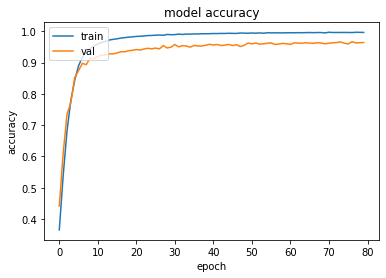

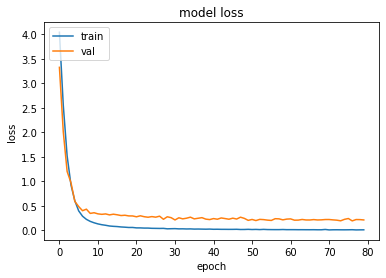

In [ ]:
from matplotlib import pyplot as plt

# plot loss and accuracy and save them
def plot_training(loss, val_loss, acc, val_acc):
  plt.plot(acc) 
  plt.plot(val_acc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig(PLOT_PATH.format('AE_accuracy'))
  plt.show()

  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig(PLOT_PATH.format('AE_loss'))
  plt.show()

df = pd.read_csv(HISTORY_PATH.format("AE"), keep_default_na=False) 
plot_training(df.iloc[:,2], df.iloc[:,4], df.iloc[:,1], df.iloc[:,3])

As we can see, training data accuracy is great and validation accuracy is little lower (97%), but still acceptable, because significant part of incorrectly decoded words are synonyms or can be used in same context, which doesn't affect significantly quality of GAN generated samples. 


**Autoencoder test**

In [ ]:
from keras import *
import keras.backend as K
from keras.layers import *
from keras.models import load_model

# load model
def load_autoencoder(path):
      model = load_model(path)

      # split into encoder and decoder
      encoder = Model(model.input, model.get_layer('encoder').output)
      decoder = Model(model.get_layer('decoder_input').input, model.get_layer('decoder').output)

      # add Argmax layer to decoder to convert results to real one-hot encoding
      one_hot_to_index = Lambda(lambda x: K.cast(K.argmax(x), dtype='float32'))(decoder.output)
      decoder = Model(decoder.input, one_hot_to_index)
      return (encoder, decoder, model)

(enc, dec, model) = load_autoencoder(AE_MODEL_PATH)

As shown below, autoencoder works pretty well.<br>
There are some OOV tokens which implies too small vocabulary size.
<br>
Increasing vocabulary impacts learning abilities so we might need to deepen AE architecture.


In [ ]:
from tensorflow.keras.utils import to_categorical

# prints input and predicted sentence
def print_test(seq):
    seq = seq.reshape(1, 20)
    predicted = model.predict(seq)
    predicted = np.argmax(predicted, axis=2) # convert one-hot to standard encoding
    
    print("IN SENTENCE         {}".format(' '.join(dataLoader.tokenizer.sequences_to_texts(seq))))
    print("PREDICTED SENTENCE  {}".format(' '.join(dataLoader.tokenizer.sequences_to_texts(predicted))))
    print("----------------------------")


for i in range(65000, 70000, 100):
  print_test(data[i])

IN SENTENCE         a toy ship a few friends who acted in community theater and the <OOV> <OOV> you can make a film
PREDICTED SENTENCE  a theater gets a few friends who acted in miles theater and the <OOV> <OOV> you can make a film
----------------------------
IN SENTENCE         this is the best series of its type i've seen all year <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
PREDICTED SENTENCE  this is the best series of its type i've seen all year <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
----------------------------
IN SENTENCE         the music graphics and the world created are gorgeous and it really stands above most other modern animated works <OOV>
PREDICTED SENTENCE  the music graphics and the world created are gorgeous and it really stands above most other modern animated works <OOV>
----------------------------
IN SENTENCE         good not for the sake of my 10 bucks or 2 hours but for the sake of these <OOV> careers
PREDICTED SENTENCE  good not for the sake of my

**GAN / WGAN**




Commented fragments of code show changes between GAN and WGAN models.

In [ ]:
from keras.constraints import Constraint

# weights clipping used in WGAN as simplest form of keeping Lipschitz continuity
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return K.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

const = ClipConstraint(0.01)

For both generator and discriminator/critic residual blocks will be used.

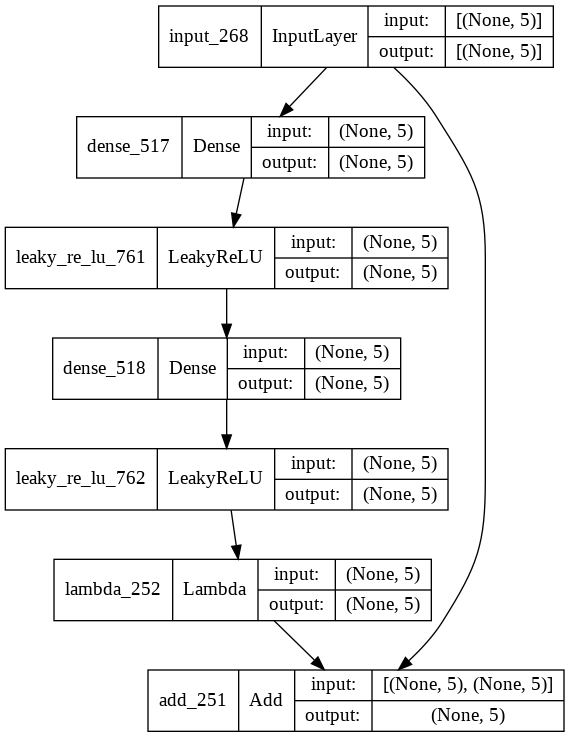

In [ ]:
from keras.initializers import *
from tensorflow.keras.utils import plot_model

def resnet_block(size, leak=0.1, const=None):
  in_layer = Input(shape=(size,))
  model = Dense(size, kernel_initializer=HeNormal(), kernel_constraint=const)(in_layer)
  model = LeakyReLU(alpha=leak)(model)
  model = Dense(size, kernel_initializer=HeNormal(), kernel_constraint=const)(model)
  model = LeakyReLU(alpha=leak)(model)
  model = Lambda(lambda x: x * 0.3)(model)
  model = Add()([model, in_layer])
  # model = LeakyReLU(alpha=leak)(model) # WGAN
  return Model(in_layer, model)

plot_model(resnet_block(5), show_shapes=True, show_layer_names=True,)


In [ ]:
import keras.backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.compat.v1.losses import sigmoid_cross_entropy

# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
  return K.mean(y_true * y_pred)
 


def get_discriminator(layers, dim):
  model = Sequential(name="Discriminator")
  model.add(Input(shape=(dim,)))
  model.add(GaussianNoise(0.1))
  for i in range(layers):
    model.add(resnet_block(dim, 0.2)) 
  # model.add(Dense(dim, activation='linear', kernel_constraint=ClipConstraint(0.001))) # WGAN
  model.add(Dense(dim, activation='linear')) # , kernel_constraint=ClipConstraint(0.001) in WGAN
  # model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1, activation='sigmoid')) # GAN
  # model.add(Dense(1, activation='linear', kernel_constraint=ClipConstraint(0.001))) # WGAN
  return model


def get_generator(layers, dim):
  model = Sequential(name="Generator")
  model.add(Input(shape=(dim,)))
  model.add(Dropout(0.5))
  model.add(Dense(dim))
  # model.add(LeakyReLU(alpha=0.2)) # might want to experiment with this
  for i in range(layers):
    model.add(resnet_block(dim, 0.2))
  # model.add(ReLU())
    # model.add(GaussianNoise(0.05))
  return model


def get_gan(gen_layers, disc_layers, dim):
  opt = Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.999)
  # opt = RMSprop(learning_rate=0.00005) # WGAN
  gen = get_generator(gen_layers, dim)
  disc = get_discriminator(disc_layers, dim)
  disc.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])
  # disc.compile(loss=wasserstein_loss, optimizer=opt, metrics=['accuracy'])
  # disc.summary()

  opt = Adam(learning_rate=0.0005, beta_1=0.5, beta_2=0.999)
  # opt = RMSprop(learning_rate=0.00005)
  disc.trainable = False
  model = Sequential(name="GAN")
  model.add(Input(shape=(dim,)))
  model.add(gen)
  model.add(disc)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])
  return (gen, disc, model)

In [ ]:
(gen, disc, gan) = get_gan(10, 10, ENCODED_VECTOR_LEN)

gen.summary()
disc.summary()
gan.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               90300     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 300)               0         
                                                                 
 model_4 (Functional)        (None, 300)               180600    
                                                                 
 model_5 (Functional)        (None, 300)               180600    
                                                                 
 model_6 (Functional)        (None, 300)               180600    
                                                                 
 model_7 (Functional)        (None, 300)               18

BLEU score will be used as one of measurements of quality.  
Unfourtunetly, creating measurement that perfectly reflects humans judgment is hard. BLEU is most commonly used method, but it doesn't actually understand sentences, just compares N-grams.

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

reference = [s.split(' ') for s in dataLoader.tokenizer.sequences_to_texts(dataLoader.tokenizer.texts_to_sequences(dataLoader.sentences))]

def bleu(sentences):
  converted =  [s.split(' ') for s in sentences]
  sum = 0
  for c in converted:
    sum += sentence_bleu(reference[:70000], c)
  return sum / len(sentences)


In [ ]:
import time

class GAN:
  def __init__(self, disc_dep=20, gen_dep=20, dim=ENCODED_VECTOR_LEN, encoder=None, decoder=None, tokenizer=None, load_path=''):
    self.generator, self.discriminator, self.gan = get_gan(gen_dep, disc_dep, dim)
    self.dim = dim
    self.data = None
    self.encoder = encoder
    self.decoder = decoder
    self.history = None
    self.tokenizer = tokenizer


  def __on_epoch_end(self, index, save_folder, save_step, report_step, log_step):
    if index % report_step == 0:
      self.report(index, log_step)
    if index % save_step == 0 and index > 0:
      self.save(save_folder + "/GANnormal_epoch{}".format(index))
    np.random.shuffle(self.data)
  
  def __epoch_len(self, batch_size):
    return int(np.ceil(len(self.data) / float(batch_size)))
  
  def __labels_vector(self, batch_size, real=True):
    # result = np.ones(shape=(batch_size, 1)) # WGAN -1, 1 GAN 1, 0
    # result += np.random.rand(batch_size, 1) * 0.4
    # result -= 0.2
    # if real:
    #   return -result
    # return result
    smooth = 0.2
    result = np.ones(shape=(batch_size, 1)) 
    if real:
      smooth = -smooth
    else:
      result = np.zeros(shape=(batch_size, 1)) 
    result += np.random.rand(batch_size, 1) * smooth
    return result


  def __random_vectors(self, batch_size):
    return np.random.normal(size=(batch_size, self.dim))

  def __real_vectors(self, batch_size, idx):
    return self.encoder.predict(self.data[idx * batch_size:(idx + 1) * batch_size])

  def __random_real_vectors(self, batch_size):
    return self.encoder.predict(self.data[np.random.choice(self.data.shape[0], batch_size, replace=False)])

  def report(self, epoch_ind, i_step):
    current = self.history[(self.history[:,0] <= epoch_ind) & (self.history[:,0] >= 0)]
   
    plt.plot(current[:,2]) 
    plt.plot(current[:,4]) 
    plt.gca().set_ylim([-10, 10])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('iteration x'  + str(i_step))
    plt.legend(['generator', 'discriminator'], loc='upper left')
    plt.savefig(PLOT_PATH.format('GAN_loss_epoch_' + str(epoch_ind)))
    plt.show()

    plt.plot(current[:,3])
    plt.plot(current[:,5])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('iteration x'  + str(i_step))
    plt.legend(['generator', 'discriminator'], loc='upper left')
    plt.savefig(PLOT_PATH.format('GAN_accuracy_epoch_' + str(epoch_ind)))
    plt.show()

    plt.plot(current[:,6]) 
    plt.plot(current[:,8]) 
    plt.gca().set_ylim([-10, 10])
    plt.title('discriminator loss')
    plt.ylabel('loss')
    plt.xlabel('iteration x'  + str(i_step))
    plt.legend(['real', 'fake'], loc='upper left')
    plt.savefig(PLOT_PATH.format('GAN_loss_epoch_rf_' + str(epoch_ind)))
    plt.show()

    plt.plot(current[:,7])
    plt.plot(current[:,9])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('iteration x'  + str(i_step))
    plt.legend(['real', 'fake'], loc='upper left')
    plt.savefig(PLOT_PATH.format('GAN_accuracy_epoch_rf_' + str(epoch_ind)))
    plt.show()

    if self.tokenizer != None:
      generated = self.generate(30)
      predicted = self.decoder.predict(generated)
      converted = self.tokenizer.sequences_to_texts(predicted.astype("int").tolist())
      for conv in converted:
        print(conv)
      print("BLEU score = {}".format(bleu(converted)))
  
  def save(self, dest_folder):
    self.gan.save(dest_folder + "GAN")
    self.discriminator.save(dest_folder + "DIS")
    self.generator.save(dest_folder + "GEN")

  def generate(self, batch_size):
    return self.generator.predict(self.__random_vectors(batch_size))

  def __train_disc(self, batch_size=128, idx=0):
    half_batch = int(batch_size / 2)
    x = self.__real_vectors(half_batch, idx)
    y = self.__labels_vector(half_batch, True)
    y = y[:len(x)]
    loss, acc = self.discriminator.train_on_batch(x, y)
    x = self.generator.predict(self.__random_vectors(half_batch))
    y = self.__labels_vector(half_batch, False)
    loss2, acc2 = self.discriminator.train_on_batch(x, y)
    return loss, loss2, acc, acc2

  def __train_gen(self, batch_size=128):
    x, y = self.__random_vectors(batch_size), self.__labels_vector(batch_size, True) 
    return self.gan.train_on_batch(x, y)

  def train(self, real_data=[], epochs=30, batch_size=128, save_folder="", save_step=5, report_step=1, iter_log_step=1):
    self.data = real_data
    half_batch = int(batch_size / 2)
    epoch_len = self.__epoch_len(half_batch)
    self.history = np.empty((0, 10))
    dloss=200
    for epoch_ind in range(epochs):
      epoch_start_time = time.time()
      # n_disc = 10
      # n_gen = 1
      # if epoch_ind > 2:
      #   n_disc = 5
      for idx in range(epoch_len):
        ##
        ## Different approaches to model learning algorithm
        ##
        # for _ in range(n_disc):
        #   discriminator_loss, discriminator_loss_f, discriminator_acc, discriminator_acc_f = self.__train_disc(batch_size, np.random.randint(0, epoch_len))

        # for _ in range(n_gen):
        #   generator_loss, generator_acc = self.__train_gen(batch_size)

        # i = 0
        # discriminator_loss, discriminator_loss_f, discriminator_acc, discriminator_acc_f = self.__train_disc(batch_size, idx)
        # for r in range(n_disc):
        #   discriminator_loss, discriminator_loss_f, discriminator_acc, discriminator_acc_f = self.__train_disc(batch_size, np.random.randint(0, epoch_len))
        # generator_loss, generator_acc = self.__train_gen(batch_size)
        i = 0
        discriminator_loss, discriminator_loss_f, discriminator_acc, discriminator_acc_f = self.__train_disc(batch_size, idx)
        while discriminator_loss < 100 and discriminator_loss > 0.5 and i < 10:
            i += 1
            discriminator_loss, discriminator_loss_f, discriminator_acc, discriminator_acc_f = self.__train_disc(batch_size, idx)
        
        i = 0
        generator_loss, generator_acc = self.__train_gen(batch_size)
        while generator_loss < 100 and generator_loss > 0.5 and i < 30:
            i += 1
            generator_loss, generator_acc = self.__train_gen(batch_size)
      
        results = [epoch_ind, idx, generator_loss, generator_acc, 0.5*(discriminator_loss+discriminator_loss_f), 0.5*(discriminator_acc+discriminator_acc_f), discriminator_loss, discriminator_acc, discriminator_loss_f, discriminator_acc_f]
        if idx % iter_log_step == 0:
          self.history = np.append(self.history, np.asarray([results]), axis=0)
        print("\rEpoch {}/{}, iter={}/{}, g_loss={:.6f}, g_accuracy={:.6f}, d_loss={:.6f}, d_acc={:.6f}, d_loss_r={:.6f}, d_acc_r={:.6f}, d_loss_f={:.6f}, d_acc_f={:.6f}  {}s".format(results[0], epochs, results[1], epoch_len, results[2], results[3], results[4], results[5], results[6], results[7], results[8], results[9], int(time.time() - epoch_start_time)), end="")
      self.__on_epoch_end(epoch_ind, save_folder, save_step, report_step, iter_log_step)
      print()
    self.report()
    return self.history




# First WGAN model

Accuracy plots should be ignored in results below because:


*   Accuracy is not great measurement for GANs
*   Label smoothing is used so accuracy is 0 all the time anyway



In [ ]:
from copy import deepcopy

#WGAN
train_data = deepcopy(data)[:70000]
print(train_data.shape) 
final_model = GAN(disc_dep=35, gen_dep=35, dim=ENCODED_VECTOR_LEN, encoder=enc, decoder=dec, tokenizer=dataLoader.tokenizer)

(70000, 20)


Epoch 0/15, iter=1093/1094, g_loss=0.000115, g_accuracy=0.000000, d_loss=-0.000035, d_acc=0.000000, d_loss_r=-0.000131, d_acc_r=0.000000, d_loss_f=0.000061, d_acc_f=0.000000  1405s

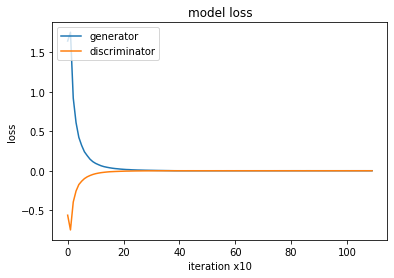

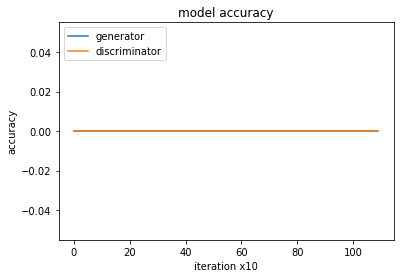

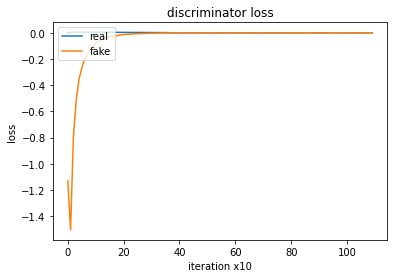

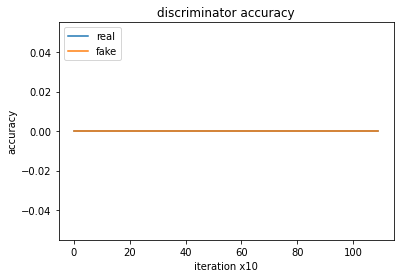

his are that for his media for <OOV> hits <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
my characters behavior best my wanna australia too copy added and in case secret <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
what word of of her describes disney gives than 2005 simply unnecessary arnold rave <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
the reaction score one the existence listed there austen only long mask to spell we've <OOV> <OOV> <OOV> <OOV> <OOV>
no if that of what robert goes as budget unnecessary comments <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
<OOV> cover here my me eye for by <OOV> price <OOV> showtime <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
first board but title that red my by test came pick on <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
and voices that of my n than experiment its plot should career <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
gives it because wrote <OOV> what cgi up <OOV> dvd guess describes won donald gordon <OOV> <OOV> <O

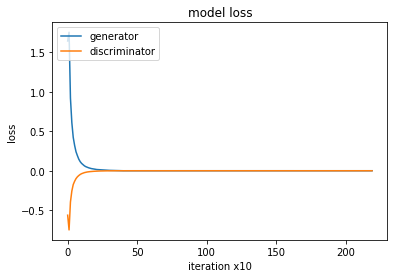

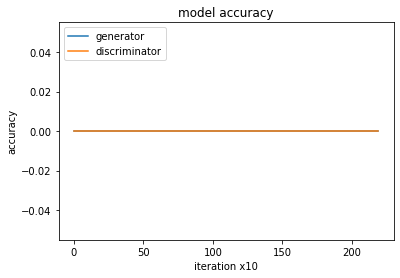

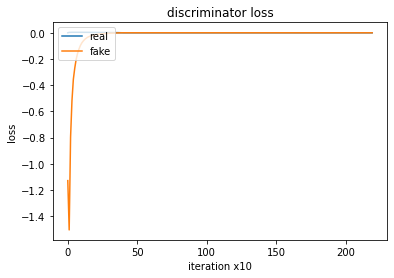

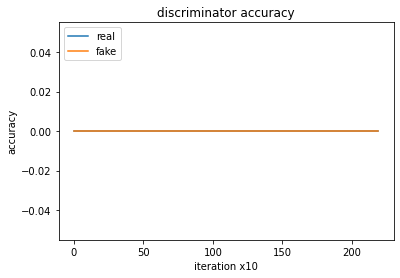

a very note t eaten is rather can all <OOV> 1982 here hardcore <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
the an creature elvira hidden john what jackson hidden india <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
very delightful because it that road impression extremely extremely control line <OOV> returning should pick away cross <OOV> <OOV> <OOV>
no thing guess calls comes to using myself kansas europe himself <OOV> romp <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
quick it's comes one upon story dog lake los <OOV> mansion <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
what thought gives made this title netflix for for about europe wing for <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
an guy hidden life duck the novel its <OOV> 1993 <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
as clue once one map as the europe someone known based <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
one seeing book episode bible what elizabeth witness felt the higher whi

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch1DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch1GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 2/15, iter=1093/1094, g_loss=0.000210, g_accuracy=0.000000, d_loss=-0.000063, d_acc=0.000000, d_loss_r=-0.000083, d_acc_r=0.000000, d_loss_f=-0.000044, d_acc_f=0.000000  1398s

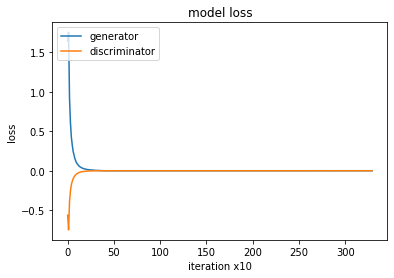

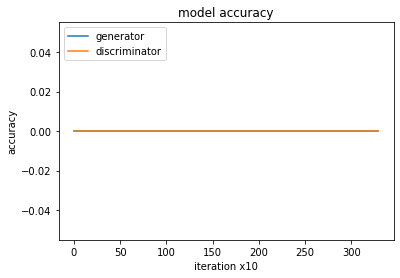

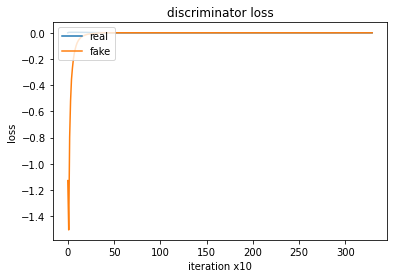

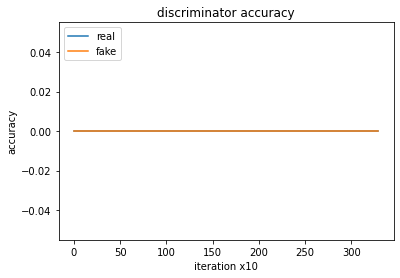

called writer character fantastic that's no stranger walked out game it proved murder in jonathan reeves artist lead both more
idea play and one for no tyler play right but for law ray eighties reeves team for describes word using
the worst is terrible disney it's no flash ingrid an canadian is exciting saw into england <OOV> <OOV> <OOV> <OOV>
the weak 4 what idea we've starts date so lead crew <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
what it redemption made perhaps chaplin across this is in of <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
before it at last positive this marriage follows but just is room 3 before 1 of second place great some
hell europe is word just no by creature using europe succeeds hollywood dragon <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
say it it movie exactly no than followed what just plot finally <OOV> england <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
a original inaccurate original dvd no anna became on offer is follows party of england austen 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.566384607532763
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch2GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch2DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch2GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 3/15, iter=1093/1094, g_loss=-0.000010, g_accuracy=0.000000, d_loss=-0.000022, d_acc=0.000000, d_loss_r=-0.000231, d_acc_r=0.000000, d_loss_f=0.000186, d_acc_f=0.000000  1394s

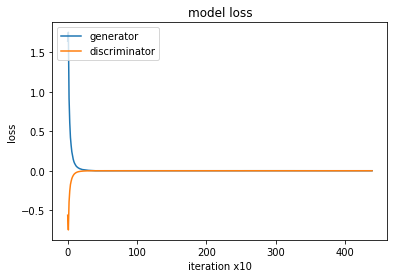

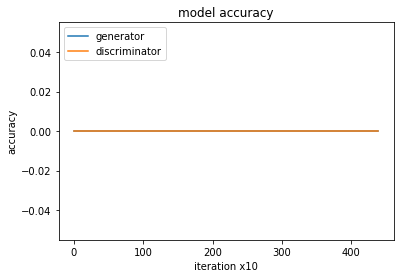

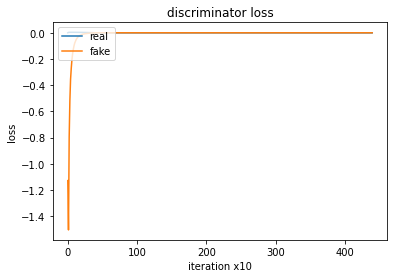

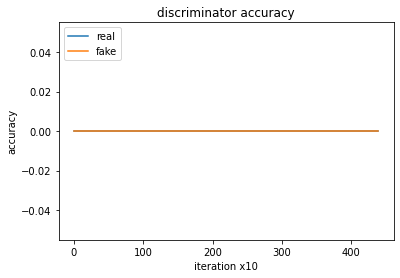

opens it's julia here me story rocky the off example scifi that hero work powers brother filmmaker <OOV> for connection
ray what only best book title open in private documentary law law evil house house secret team title open life
the m with richard jamie eric friend in friend country to and century century england eighties dean germany america friend
this writer or one return paul hidden sea or using hits that ii used president president <OOV> <OOV> <OOV> <OOV>
europe bob is it and for 9 in in action <OOV> team especially murdered <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
as endless if best title one open a eye day since team artists johnny england halloween talkie writer a complete
on strange <OOV> on <OOV> <OOV> rocky his son making for theme today wwii late freeman 1930s lead <OOV> young
angel player not it universe out play moon lake lake crash for era follows york former ranger <OOV> <OOV> <OOV>
brian literally as title for one 9 land dead game earth states but during freeman freeman l

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.5305647513747774
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch3GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch3DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch3GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 4/15, iter=1093/1094, g_loss=0.000011, g_accuracy=0.000000, d_loss=-0.000018, d_acc=0.000000, d_loss_r=-0.000194, d_acc_r=0.000000, d_loss_f=0.000159, d_acc_f=0.000000  1397s

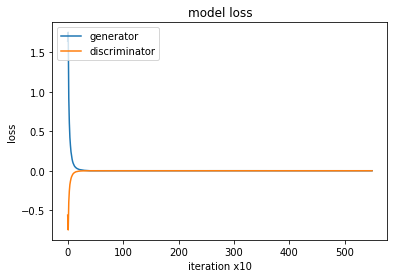

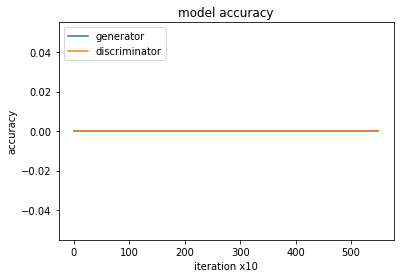

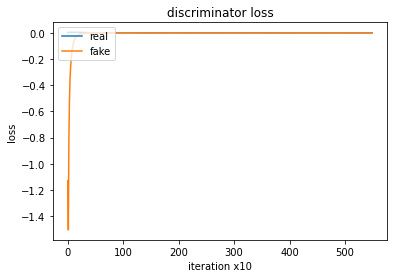

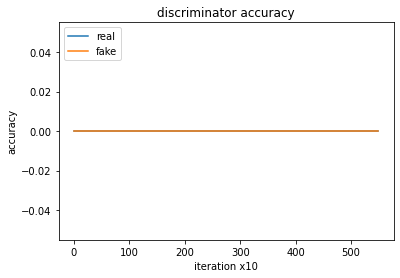

the opens <OOV> version my feet myself looking screen herself officers east england four eighties 1939 america power 1980's inside
the monster that original by makes stand stands blue opening with universe ii wwii england communist africa team using friend
play and title screen sound julie drive live its states century four favourite team hidden using oil live making among
the <OOV> scientist version in stay sent set public score <OOV> team york house san main leaving down set searching
by works <OOV> made set different by looking office exactly government history century four 1939 1933 task basic 9 road
one hero <OOV> screen the normal his to public experiment universe today wwii house favourite lead the normal moon to
stranger who scientist on providing control position near winning poor officers art east san comedian nazi nazi sons ward using
supposed and <OOV> dvd hidden possible burns halfway credits about work works england four dean team hidden possible fire camera
play characte

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.582361285521571
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch4GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch4DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch4GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 5/15, iter=1093/1094, g_loss=-0.000072, g_accuracy=0.000000, d_loss=-0.000019, d_acc=0.000000, d_loss_r=-0.000237, d_acc_r=0.000000, d_loss_f=0.000200, d_acc_f=0.000000  1410s

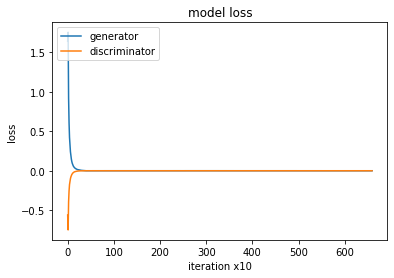

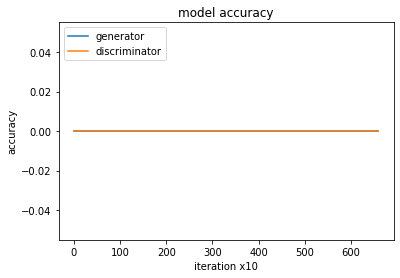

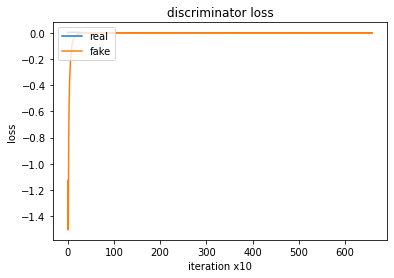

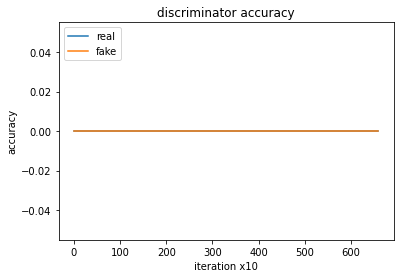

another writer writer single check that's self very ring footage is cities music before four african germany too comparison meaning
the 60's enemy richard against potential thin ring screen used ancient era following four florida national lead potential eye out
hidden <OOV> director title point self control place available no team following four 1933 lead frame self land office about
the the <OOV> other quick argento oscar into filming on continuity society england four the fictional despite charlie in set
side that about seeing as potential as play thriller just artist night england single <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
captain bbc 2007 africa one river city run though team took late four san 1st east never law team invasion
set if but made too some fire put available about location follows four four team seemingly full planet put available
the novel it with in semi very in nicely as famous wars following halloween trek captain her bore meaning what
another is a issue itself equa

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.5892621768708238
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch5GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch5DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch5GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 6/15, iter=1093/1094, g_loss=0.000098, g_accuracy=0.000000, d_loss=-0.000021, d_acc=0.000000, d_loss_r=-0.000127, d_acc_r=0.000000, d_loss_f=0.000085, d_acc_f=0.000000  1405s

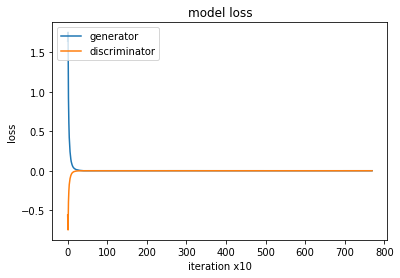

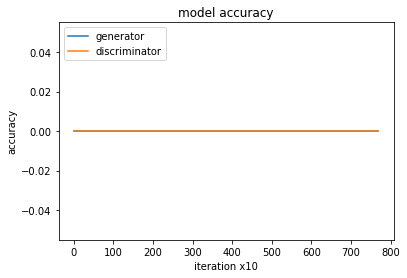

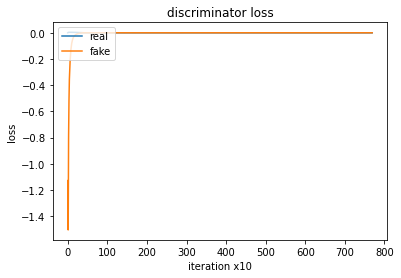

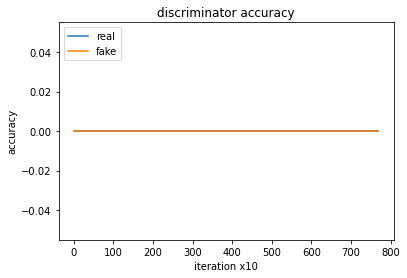

my truth <OOV> after high sea join journey short thus ii law four four around 12 lives desert sounds army
a <OOV> evil however attention myself set building positive law took through four south doing leaving car account other society
city all those released point complete journey post about states took four four australian 9 journey west awards states politics
the search <OOV> almost closer self can screen brief contained 1960s three four four 11 parents trip video media art
side that enemy released attention completely road post its society took four four 20 feet space distribution marks team four
city all book released point while across studio motion states took communist four four leaving around west awards states members
an where enemy cable point eye across building code justice states took four four post 30 car post accurate states
a where soviet debut possible north trip distribution key taken 11 four sons robin post east building awards countries war
play <OOV> garbage across 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.49211290074641306
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch6GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch6DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch6GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 7/15, iter=1093/1094, g_loss=0.000057, g_accuracy=0.000000, d_loss=0.000008, d_acc=0.000000, d_loss_r=-0.000092, d_acc_r=0.000000, d_loss_f=0.000107, d_acc_f=0.000000  1403s

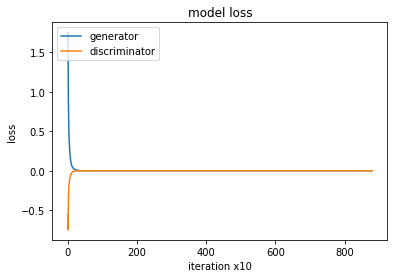

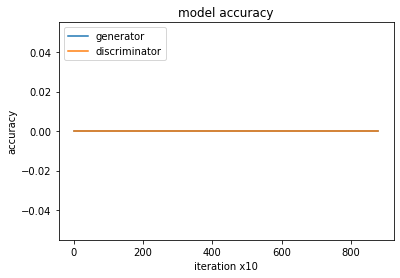

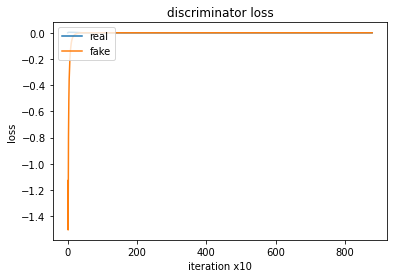

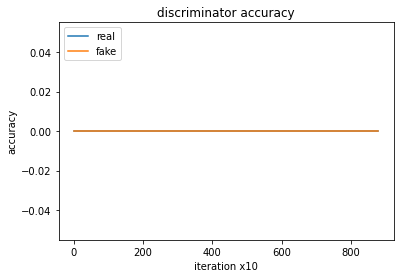

center <OOV> film across point land post run taking states took four four step post prison viewing taking system communist
a all that winner point england plane entire office history states three four four relatively six oil cities features war
road and films offer 9 journey across distribution wwii law four four post 9 moving post disney's society west four
drive and best released step onto run run held 11 four four 11 rights 9 post closer motion place four
another that but made a feet stumble wide distribution about states took four four florida little 9 20 post credit
through all there winner a larger headed near star took system states four four four early 11 west system producer
side all and just play potential 3rd up commercial line cast members following four four 6 full 12 side rated
side there just released odd literally out distribution about crew took four robin wide rocks empty west rated known religion
a work there release title potential moon into short date works states 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.6265989195811859
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch7GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch7DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch7GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 8/15, iter=1093/1094, g_loss=0.000069, g_accuracy=0.000000, d_loss=-0.000005, d_acc=0.000000, d_loss_r=-0.000095, d_acc_r=0.000000, d_loss_f=0.000085, d_acc_f=0.000000  1360s

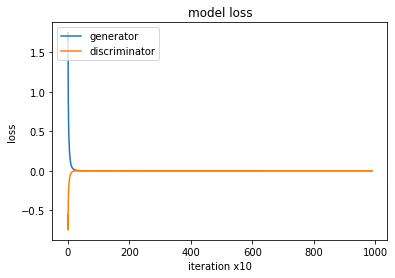

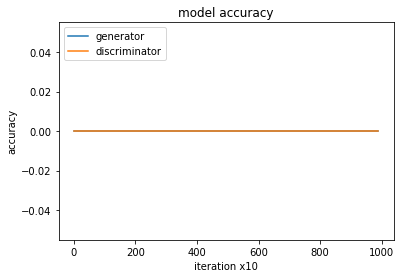

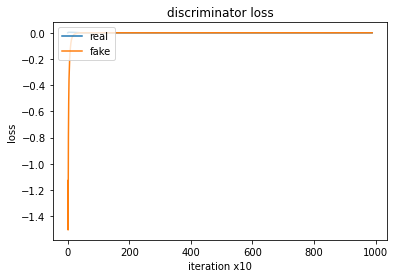

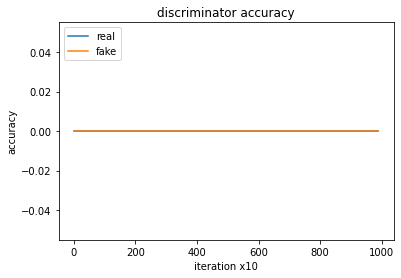

a there most released less julie across marathon simply creative took following four african odd open room west entirely particular
side all among released deal eye onto across released contained east following four four west 9 home side marks artists
a work most released point eye office west program material states during four four african beyond media journey country entirely
side if a came sea home side taking 1959 took through four four 15 year run east four through away
a all universe released point eye onto side actually used west following four four four west west marks west west
road all most released frame moon trip long system states took 11 sons four west west west awards war communist
side that a run self seat next run recognition took through four lived minutes high run 11 war four four
a <OOV> writing released extra vhs across marathon information changes west three four four giving onto straight west material west
creature that these released attention eye released four

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.5424710506410733
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch8GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch8DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch8GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 9/15, iter=1093/1094, g_loss=0.000047, g_accuracy=0.000000, d_loss=0.000016, d_acc=0.000000, d_loss_r=-0.000050, d_acc_r=0.000000, d_loss_f=0.000082, d_acc_f=0.000000  1362s

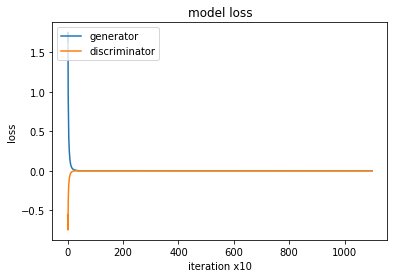

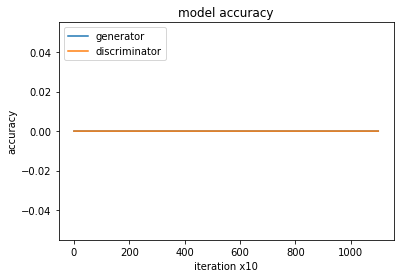

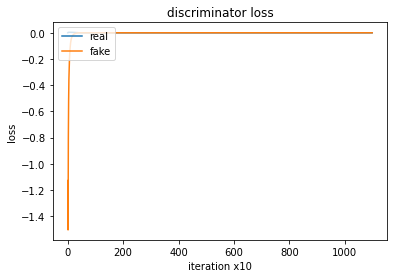

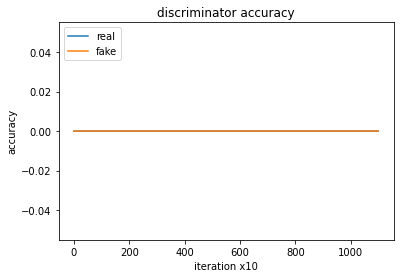

light <OOV> took far frame from around side run end east texas four four four west six west west late
side that things far different fire across post almost society west 11 four four 11 class west awards system four
his state if released frame or journey space distribution about members following four new four looking parents space building aspect
side that piece came deep seat side marathon important members following four four getting feet space west educational took four
small that lou another odd drew road running information society states following four top unlikely post car post information society
land africa any whose head apartment taking research members four four moving hold around east 6 states religion four side
side <OOV> both across different sale across starting information states took four new looking post journey post motion system communist
side that writing across social commentary frame building simply used east following four four beyond grant journey building we

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.5910561365947173
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch9GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch9DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch9GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 10/15, iter=1093/1094, g_loss=-0.000141, g_accuracy=0.000000, d_loss=0.000011, d_acc=0.000000, d_loss_r=-0.000248, d_acc_r=0.000000, d_loss_f=0.000269, d_acc_f=0.000000  1369s

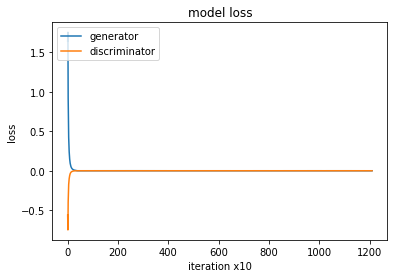

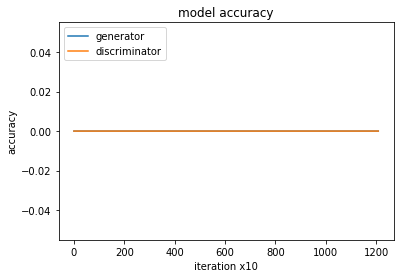

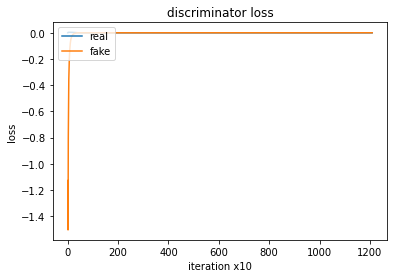

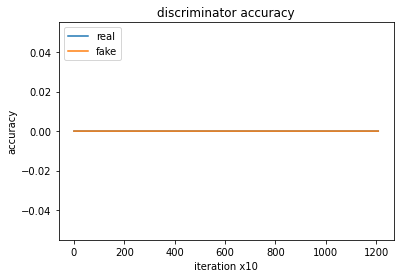

land in both released problems or along around released regarding society took four four six east west marks society west
group <OOV> evil near inner 12 high minute historical day following four four six west years west two four apartment
middle and recorded frame depth home home starting system east four four around east west east west east four around
into <OOV> enemy far social ed frame building distribution ideas states following four four 12 suburban west foreign states four
side there of released normal drew across building recorded society took four four high east space west awards system four
head <OOV> a office unnecessary coach onto building distribution law states following four four leaving heads west regular society west
side <OOV> of released self leaving across star system crew took four four 40 east space star system system four
desert and film closer semi home high classes system 11 four four close east class 11 war four four high
group <OOV> documentary closer social 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.5690918449109372
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch10GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch10DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch10GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 11/15, iter=1093/1094, g_loss=0.000016, g_accuracy=0.000000, d_loss=0.000004, d_acc=0.000000, d_loss_r=-0.000124, d_acc_r=0.000000, d_loss_f=0.000132, d_acc_f=0.000000  1373s

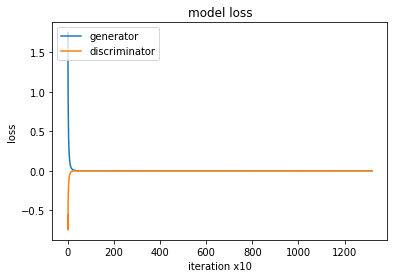

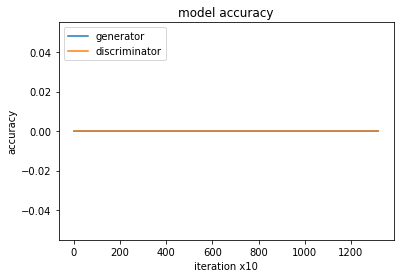

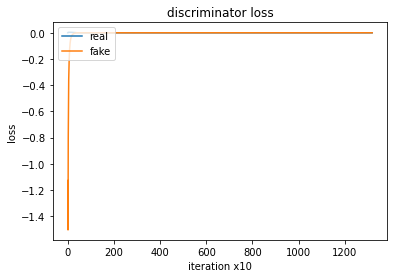

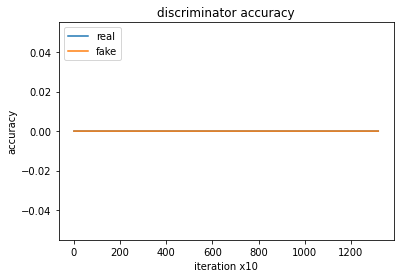

city <OOV> film released different drawn across running distribution art law three four local 30 moving middle awards war four
side all writing released frame fire across straight studio held east following four four six 15 west west west four
group the most across frame birth around west historical continuity law three four four unlikely feet around west writing society
group all creative released frame eye onto space unit nothing east took three four four rights moving school war art
side all most released point eye plane side distribution about members following four four west post home west war west
room <OOV> review far depth straight run classes states took four four 30 home run war system four four across
light the universe released social freedom car building camera holds east following four four six west west west west west
side my writing released point eye around middle office 4 states took four old feet east middle west marks society
form the among released frame swedish ac

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.6220317528960657
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch11GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch11DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch11GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 12/15, iter=1093/1094, g_loss=-0.000077, g_accuracy=0.000000, d_loss=0.000006, d_acc=0.000000, d_loss_r=-0.000203, d_acc_r=0.000000, d_loss_f=0.000216, d_acc_f=0.000000  1375s

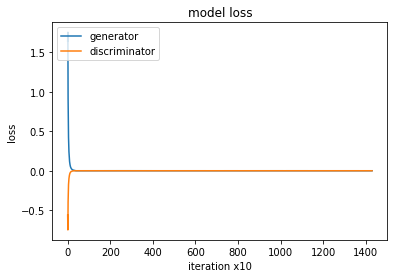

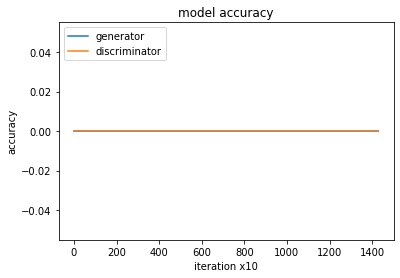

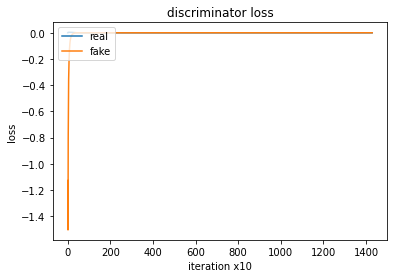

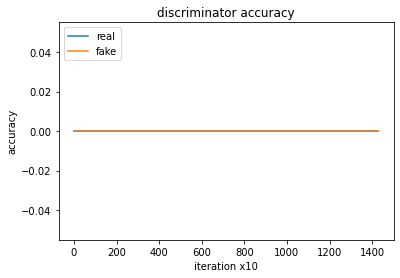

a the that released depth eye plane level distribution no members following four major 40 edge break west distribution world
identity <OOV> universe near social commentary onto building distribution recorded east following four four four 11 west 11 west west
side that writing released frame julie across starting information among states following four four offer foot space west credit winning
side all among released social grace onto middle distribution holds winning beginning 11 four four six 11 years 11 west
city <OOV> best released problems julie office high distribution work society took four four six broken west side distribution artists
side all among released point teeth trip around post everything system day four four six east around west 11 west
city there held frame imagery drive east east 11 west four four four rights west years 11 four four countries
his <OOV> enemy released social commentary journey building distribution holds east three four four 11 countries west 11 west

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


KeyboardInterrupt: ignored

In [ ]:
final_model.train(real_data=train_data, epochs=15, batch_size=128, save_folder=GAN_MODEL_PATH, report_step=1, save_step=1, iter_log_step=10)

# Second WGAN model

(70000, 20)
Epoch 0/15, iter=1093/1094, g_loss=-0.000020, g_accuracy=0.000000, d_loss=0.000027, d_acc=0.000000, d_loss_r=-0.000026, d_acc_r=0.000000, d_loss_f=0.000079, d_acc_f=0.000000  2044s

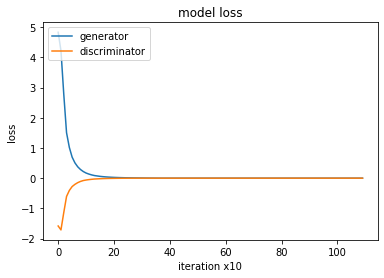

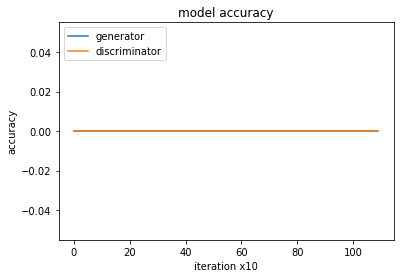

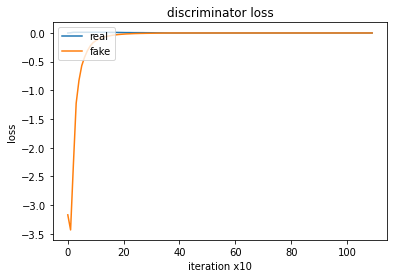

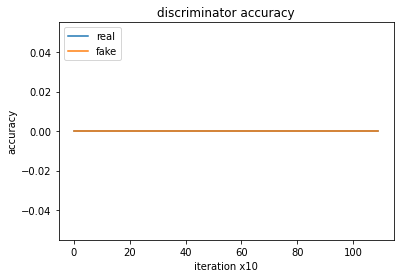

leads those the however <OOV> than <OOV> tony just comes <OOV> hbo <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
those words no title for cgi <OOV> by about <OOV> describes here <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
if no how original chaplin in gives cgi gives by richard for title vietnam or predator <OOV> <OOV> <OOV> <OOV>
burt works works lucio have through adolescent with in as movie is describes egyptian <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
episode trilogy film film <OOV> lucio text <OOV> totally rush how her films fails we've <OOV> <OOV> <OOV> <OOV> <OOV>
diane by david the the oscar title saturday week <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
if gives voice of the flawed nor in by garbage for tragedy vampire <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
it's basically title isn't lucy extremely as follows being <OOV> she part <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
jackson gives as through his wanna ' begins it's about <OOV> <OOV> mistake 

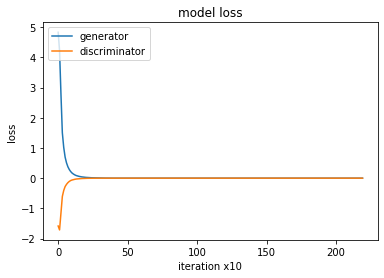

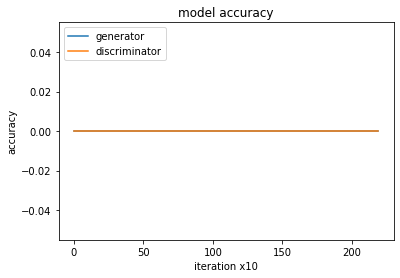

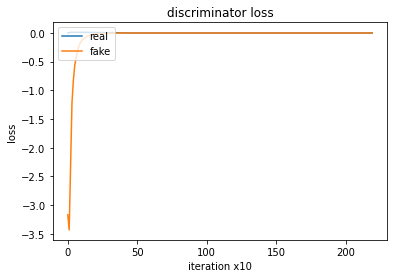

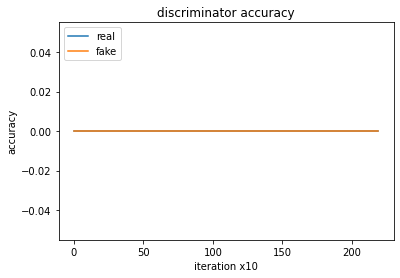

the the dallas the <OOV> free flawed me though it loud sweet cannot fight <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
that of argento wasn't <OOV> media <OOV> to philip isn't the fonda zombies <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
that of no richard <OOV> wanna murphy find am it fire meryl for games <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
the a reviewer only only informative or find though it's end hugely until <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
the for carmen she of rocky <OOV> to however <OOV> <OOV> muppet destruction <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
all europe but johnny <OOV> advertising diane begins am once shore games madness <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
that no carmen <OOV> <OOV> you're <OOV> by nicole vincent <OOV> macbeth madness <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
the the nicole disney the bringing scooby to literally vincent describes about religious <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
that about but wasn't the disney's <OOV> up  exactly <OO

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch1DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch1GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 2/15, iter=1093/1094, g_loss=0.000080, g_accuracy=0.000000, d_loss=0.000013, d_acc=0.000000, d_loss_r=0.000014, d_acc_r=0.000000, d_loss_f=0.000012, d_acc_f=0.000000  1979s

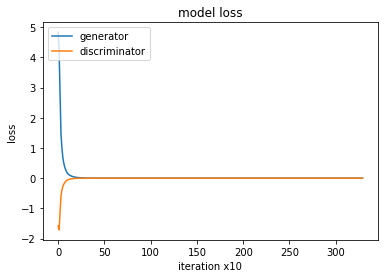

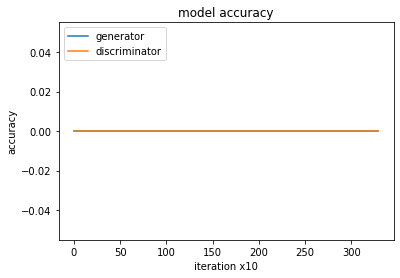

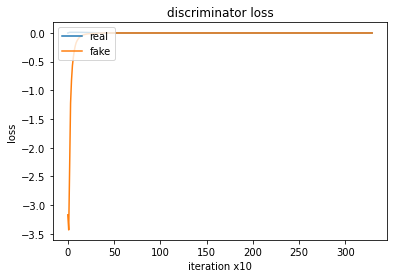

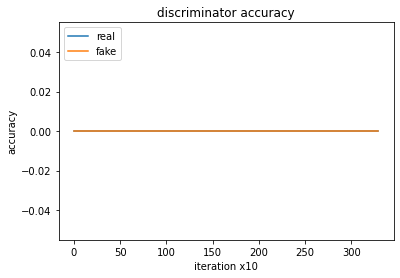

when says writing review <OOV> mass <OOV> by mirror <OOV> secret and <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
why believe noted review for n you'll <OOV> surprise as <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
you've i'll nicole diane <OOV> flash attempts fire look out <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
i'm quote other it's me oil in have just disney hbo <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
elvira describe contains original for media in reaches europe for describes <OOV> core <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
that hour about writing <OOV> standard what himself it board <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
then if just through my disc <OOV> with about came <OOV> say sopranos <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
among 2 and it that curse <OOV> allows <OOV> rush <OOV> kills robin <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
but quote alexander it's all proof jackson could catch out against cu

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch2DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch2GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 3/15, iter=1093/1094, g_loss=0.000030, g_accuracy=0.000000, d_loss=0.000026, d_acc=0.000000, d_loss_r=0.000029, d_acc_r=0.000000, d_loss_f=0.000022, d_acc_f=0.000000  1992s

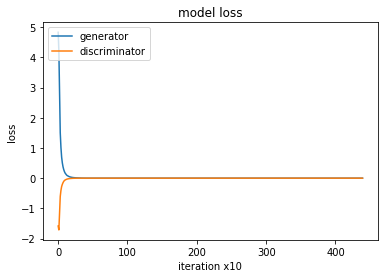

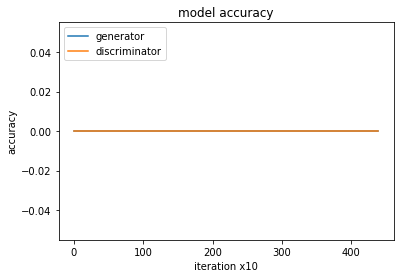

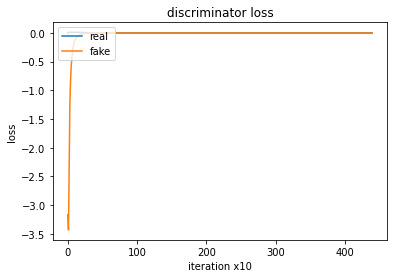

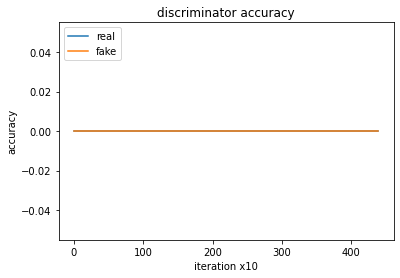

about no contains called <OOV> jess johnson find kansas time disney irish <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
writing one redemption film that michelle word kenneth with hell hell <OOV> just but redemption <OOV> <OOV> <OOV> <OOV> <OOV>
worst what vague best <OOV> for rogers out australia almost disney for mostly <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
best decent book film <OOV> its <OOV> life confused hell isn't m all <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
about no writing it's me despite the creature there's just disney irish <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
about europe contains describes <OOV> disney's out not hell <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
but alexander reason based team vehicle <OOV> <OOV> does hits happy an acting <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
worst it among regarded thomas 6 eric <OOV> vincent however made is starring in stuff <OOV> <OOV> <OOV> <OOV> <OOV>
that that morgan novel name its flesh i

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch3DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch3GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 4/15, iter=1093/1094, g_loss=0.000192, g_accuracy=0.000000, d_loss=0.000025, d_acc=0.000000, d_loss_r=0.000189, d_acc_r=0.000000, d_loss_f=-0.000139, d_acc_f=0.000000  2012s

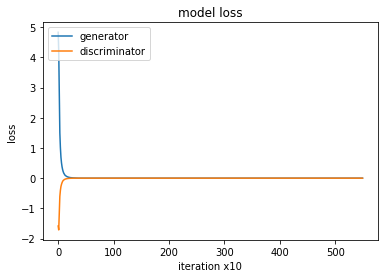

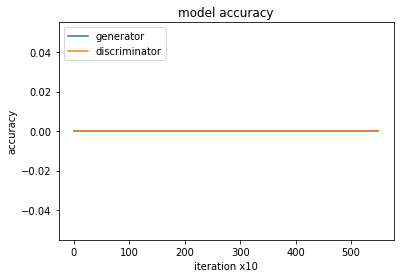

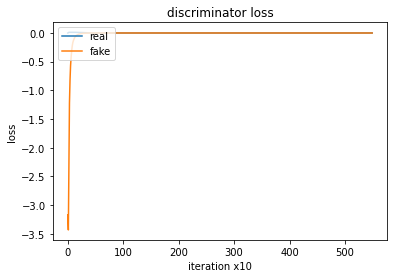

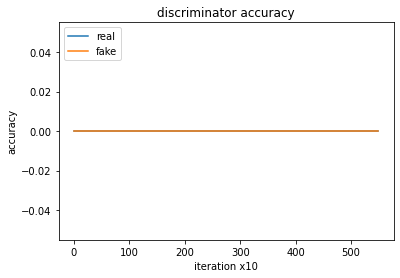

we asked those film <OOV> ingrid pacino johnson what fire sucks response host indeed for welles <OOV> <OOV> <OOV> <OOV>
about no contains just my summer from creature rush scifi <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
shame no hollywood score <OOV> myself than kenneth captain hell guess disney nor for tarzan <OOV> <OOV> <OOV> <OOV> <OOV>
disney's excellent why film <OOV> <OOV> myself with some totally alan makes writes vietnam <OOV> johnson <OOV> <OOV> <OOV> <OOV>
why as morgan cult and 1972 donald previews fred seeing it host usa week <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
nothing nothing why both disney in wanna <OOV> what myself would could fictional but that <OOV> <OOV> <OOV> <OOV> <OOV>
suppose it's andy performance ingrid disney's gordon life with sucks vincent disney been blake <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
guess about it's norman <OOV> caused in by usual that man vincent board <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
writing one writing cult <OOV> campbe

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch4DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch4GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 5/15, iter=1093/1094, g_loss=0.000275, g_accuracy=0.000000, d_loss=0.000024, d_acc=0.000000, d_loss_r=0.000280, d_acc_r=0.000000, d_loss_f=-0.000231, d_acc_f=0.000000  2013s

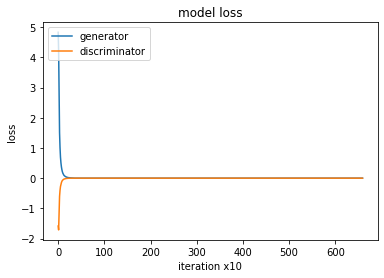

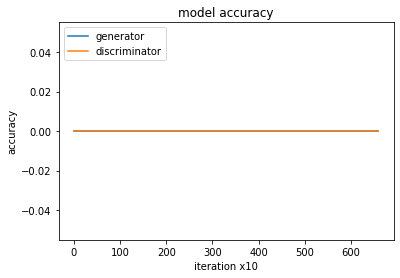

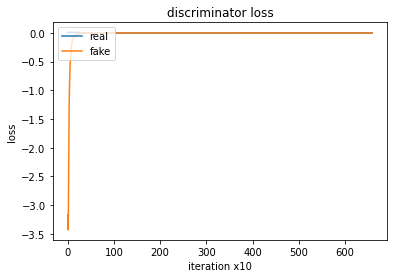

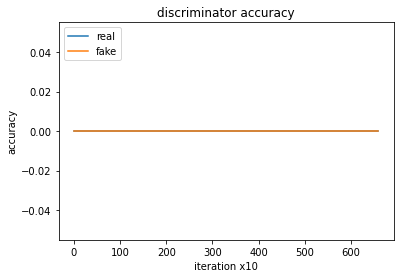

other greatest literary film <OOV> written some life she tarzan vincent describes tarzan heaven <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
no no about score me text some april philip board <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
other no book song and julie than in creature sucks succeeds disney vietnam all <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
guess no victor film <OOV> myself gordon of for sucks vincent describes fact <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
about story victor title adaptation <OOV> for gordon we're with host creature is fact me hour <OOV> <OOV> <OOV> <OOV>
about one about richard novel <OOV> wanna hitchcock's some totally tarzan makes mst3k but <OOV> h <OOV> <OOV> <OOV> <OOV>
3 film writing about however 1968 as try mind fire hell vincent and m for hour <OOV> <OOV> <OOV> <OOV>
what's film music film <OOV> pacino <OOV> for literally after man thought it <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
about no book song <OOV> myself hanks in t like isn't george 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch5DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch5GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 6/15, iter=1093/1094, g_loss=0.000335, g_accuracy=0.000000, d_loss=0.000026, d_acc=0.000000, d_loss_r=0.000337, d_acc_r=0.000000, d_loss_f=-0.000285, d_acc_f=0.000000  2024s

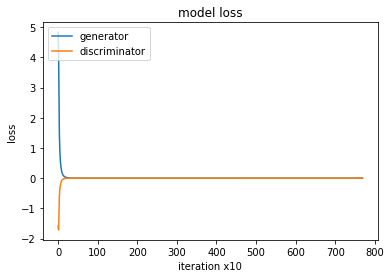

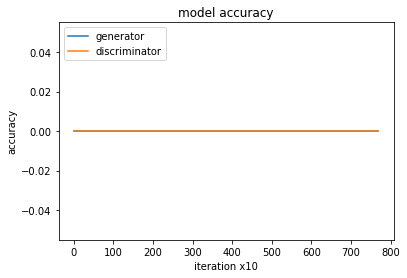

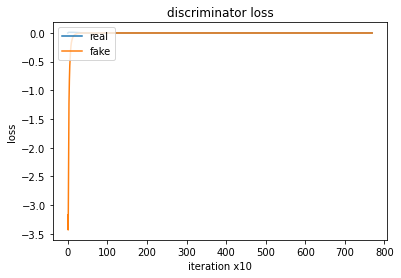

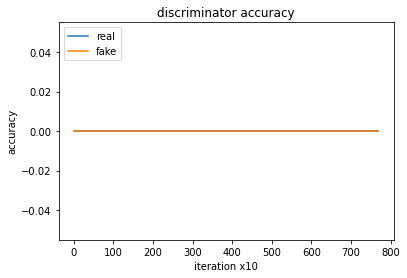

both no particular hbo <OOV> than donald earth saturday tarzan for disney it <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
worst no book installment <OOV> <OOV> disney's memory church angel danish dorothy nor keeps h <OOV> <OOV> <OOV> <OOV> <OOV>
evil script hollywood richard disney for than <OOV> life australia hell guess mst3k but keeps note <OOV> <OOV> <OOV> <OOV>
worst no evil curse <OOV> curse if the guy waiting itself as egyptian <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
both no stories cult <OOV> reynolds <OOV> evil by sucks vincent mst3k tarzan for <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
world writer music produced the were with life t after scifi is vietnam <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
among fiction fiction cast disney for clark with soul punch sucks vincent mst3k clint eating hour <OOV> <OOV> <OOV> <OOV>
about one writing song <OOV> holds julie moon with about vincent <OOV> vietnam for h <OOV> <OOV> <OOV> <OOV> <OOV>
about no stories richard <OOV> disney's julie earth <O

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch6DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch6GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 7/15, iter=1093/1094, g_loss=0.000465, g_accuracy=0.000000, d_loss=0.000029, d_acc=0.000000, d_loss_r=0.000466, d_acc_r=0.000000, d_loss_f=-0.000408, d_acc_f=0.000000  2033s

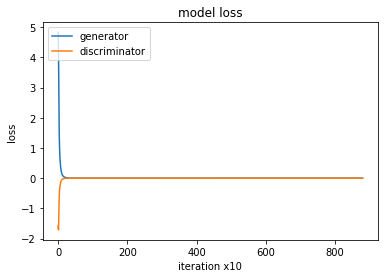

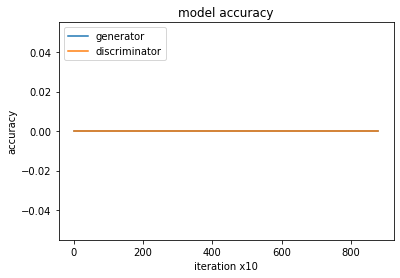

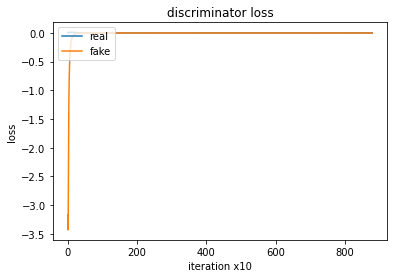

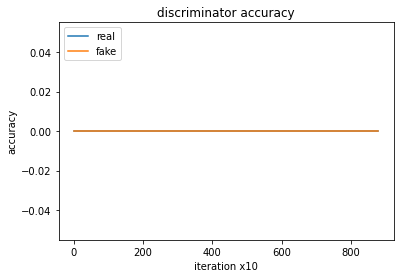

walt europe utter r and mentioned with some supposed heaven scifi disney meryl for h <OOV> <OOV> <OOV> <OOV> <OOV>
contains no victor song me disney's than life confused tarzan elvira mst3k tarzan <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
around their utter score <OOV> follow than evil man hell scifi title but on tarzan <OOV> <OOV> <OOV> <OOV> <OOV>
about no about describes name presents his plan kansas meryl cia <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
l very nicole is paul emma james human fire shines <OOV> adaptation that's what <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
particular original particular international <OOV> again with of fails sucks but mst3k danish for netflix <OOV> <OOV> <OOV> <OOV> <OOV>
perhaps no contains role name jess her dog macbeth time for irish here <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
americans no writing film novel <OOV> disney's argento rogers with movie sees she it's me guess <OOV> <OOV> <OOV> <OOV>
we again johnny calling novel all free hitch

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch7DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch7GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 8/15, iter=1093/1094, g_loss=0.000502, g_accuracy=0.000000, d_loss=0.000024, d_acc=0.000000, d_loss_r=0.000506, d_acc_r=0.000000, d_loss_f=-0.000458, d_acc_f=0.000000  2043s

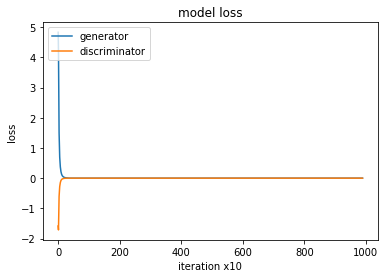

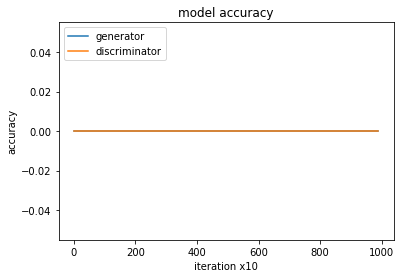

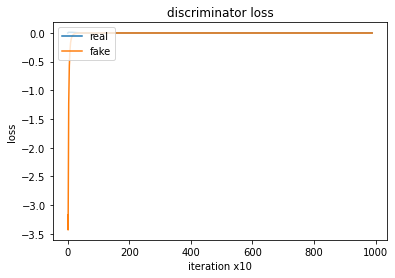

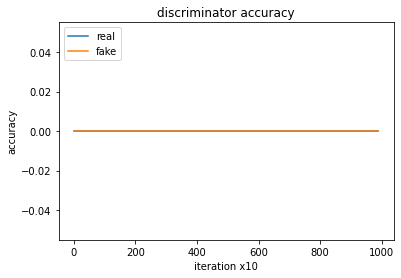

we used johnny film disney <OOV> files lucy what bell what being but what we've <OOV> <OOV> <OOV> <OOV> <OOV>
guess no victor film <OOV> ingrid than <OOV> vincent kansas hell describes elvis that hour <OOV> <OOV> <OOV> <OOV> <OOV>
about story hollywood film <OOV> title disney's in to tarzan action disney m hell <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
at of about story <OOV> page for up by this comes host about <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
about story about film <OOV> julie with <OOV> to idea test describes that's <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
thinking story of richard and walt scooby evil can hell vincent disney vietnam in <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
doubt best among his voice <OOV> below than life has this it creature it's for clark <OOV> <OOV> <OOV> <OOV>
best no writing film on it them the describes kansas it <OOV> meryl when pictures <OOV> <OOV> <OOV> <OOV> <OOV>
about part first film <OOV> mentioned memory of creature vincent vincent <OOV> joseph johnn

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.4190763150000839
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch8GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch8DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch8GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 9/15, iter=1093/1094, g_loss=0.000570, g_accuracy=0.000000, d_loss=0.000022, d_acc=0.000000, d_loss_r=0.000571, d_acc_r=0.000000, d_loss_f=-0.000527, d_acc_f=0.000000  2042s

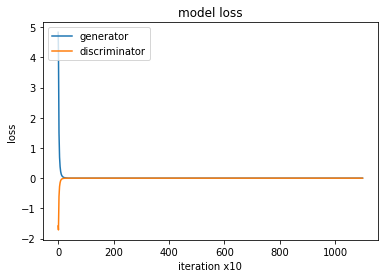

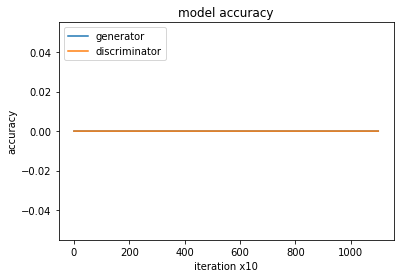

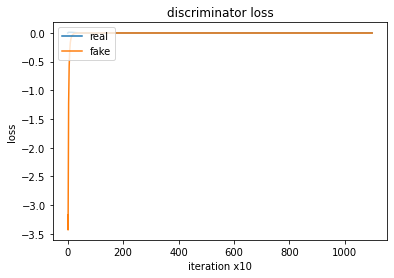

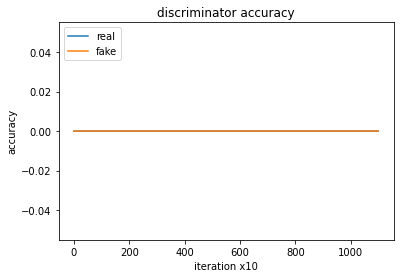

americans no each film david p how her elvira tracy vincent <OOV> egyptian simon board <OOV> <OOV> <OOV> <OOV> <OOV>
describes great busey disappointment lame in down daughter 1989 t show as <OOV> carlos literally <OOV> <OOV> <OOV> <OOV> <OOV>
during no stories cast disney <OOV> than elizabeth life be sucks it role just that tarzan <OOV> <OOV> <OOV> <OOV>
episode film music film disney <OOV> than hitchcock's of fails tracy vincent title fact for h <OOV> <OOV> <OOV> <OOV>
worst evil made called and myself gordon ray captain tarzan comes mst3k indeed for we've <OOV> <OOV> <OOV> <OOV> <OOV>
both one terrible killer festival for reaches than soul with hell would she uwe bloody h <OOV> <OOV> <OOV> <OOV>
americans both among cast novel ingrid disney's gordon johnson can catch experiment winner cast breed clark <OOV> <OOV> <OOV> <OOV>
about one first year's <OOV> jennifer <OOV> earth macbeth review supposed hbo <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
stories famous comic producer <OOV

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch9DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANsmall_epoch9GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 10/15, iter=409/1094, g_loss=0.000625, g_accuracy=0.000000, d_loss=0.000024, d_acc=0.000000, d_loss_r=0.000619, d_acc_r=0.000000, d_loss_f=-0.000571, d_acc_f=0.000000  754s

KeyboardInterrupt: ignored

In [ ]:
#WGAN
train_data = deepcopy(data)[:70000]
print(train_data.shape) 
final_model2 = GAN(disc_dep=60, gen_dep=50, dim=ENCODED_VECTOR_LEN, encoder=enc, decoder=dec, tokenizer=dataLoader.tokenizer)
final_model2.train(real_data=train_data, epochs=15, batch_size=128, save_folder=GAN_MODEL_PATH, report_step=1, save_step=1, iter_log_step=10)

# Standard GAN model

(70000, 20)
Epoch 0/20, iter=546/547, g_loss=0.562989, g_accuracy=0.000000, d_loss=0.647169, d_acc=0.000000, d_loss_r=0.682258, d_acc_r=0.000000, d_loss_f=0.612080, d_acc_f=0.000000  1126s

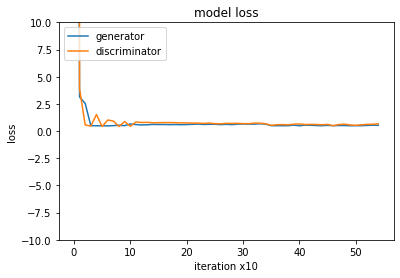

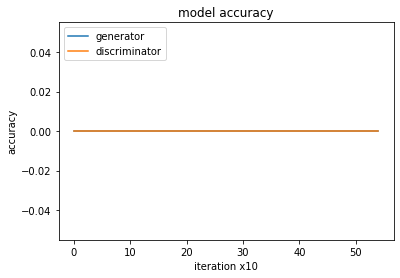

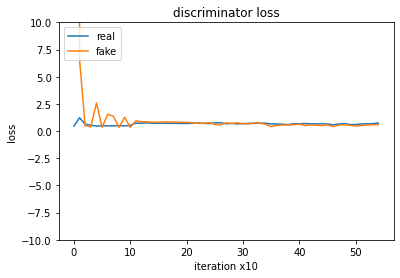

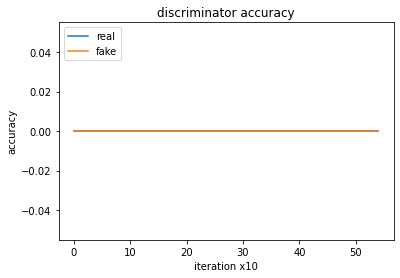

describes saving that lacks lacks means what hollywood hollywood and fatal hollywood mickey makes inspired disney became ridiculous ridiculous ridiculous
it's johnny diane eaten is vincent vincent page <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
satan wesley <OOV> europe <OOV> rather inevitable rush hollywood australia them vincent curse as norris does lacks touching anything nothing
hugh jackson tracy that here <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
1950's wwii <OOV> victor el 'the but <OOV> blue elvira fire blair vincent bell reader flawed quote pure accents hero
makes films no film ass guess for muppet however but tracy sudden credits doesn't are violence issues <OOV> <OOV> <OOV>
itself public <OOV> comic jean no very devil receives with not followed no originality 3 films it writing anything questions
it's about seagal as most in out <OOV> empire <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.5994215130559836

Epoch 1/20, iter=546/547, g_loss=0.498313, g_accuracy=0.000000, d_loss=0.529989, d_acc=0.000000, d_loss_r=0.607979, d_acc_r=0.000000, d_loss_f=0.451999, d_acc_f=0.000000  1211s

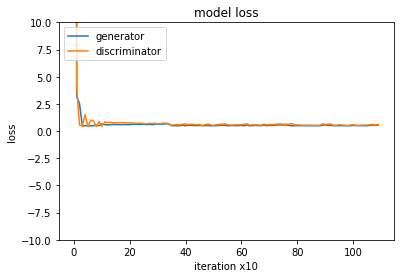

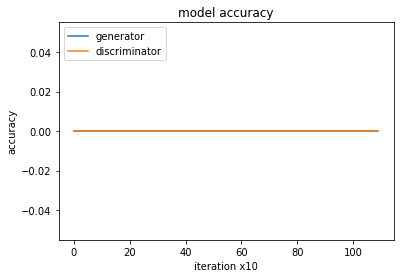

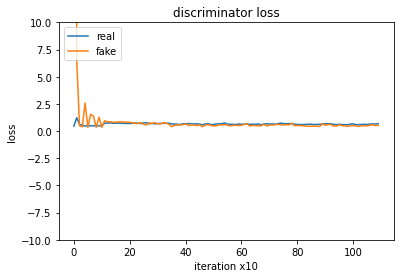

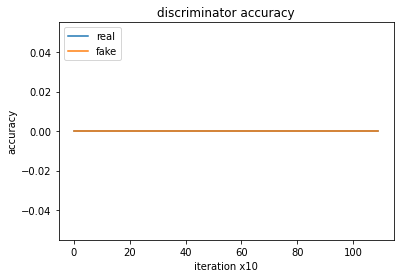

i thought although has made the lost midnight another guess a b curse heaven line for russell and at name
when movie original wasn't same monster journey what what players in particular than europe a note makes for life music
here review is <OOV> example <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
sorry i'm has proof of mtv <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
there's deserves <OOV> alan <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
oh not does for for creature <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
cant expect <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
i'm just as <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
to of about under country in bringing split front in in in the an cure th

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.6884528290293995
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANnormal_epoch1GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANnormal_epoch1DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANnormal_epoch1GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 2/20, iter=546/547, g_loss=0.499060, g_accuracy=0.000000, d_loss=0.518674, d_acc=0.000000, d_loss_r=0.586023, d_acc_r=0.000000, d_loss_f=0.451326, d_acc_f=0.000000  1229s

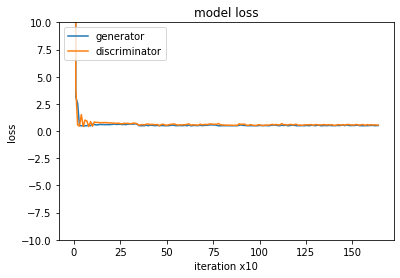

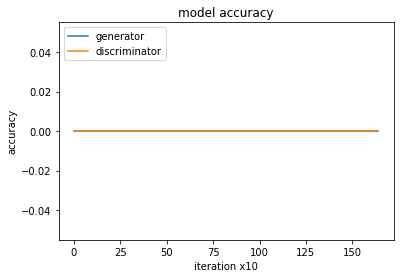

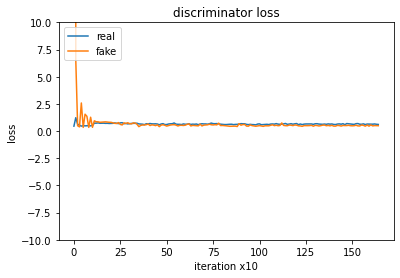

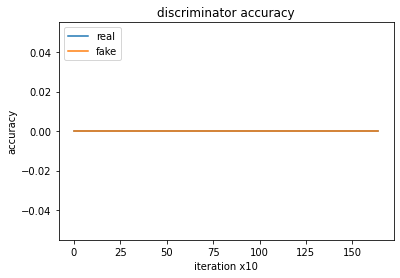

a comedy keeps makes more hell simon scifi describes <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
into my great i'll to and it coming itself while all gives for heaven almost not on all down or
angry grave many reviewers read and no same rush mine or what why will never he wants finally for angels
new mountain angel treasure a richard that it maker introduced <OOV> what about its in nothing garbage fire around from
it's guess wasn't be inevitable <OOV> but <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
charles suit asterix up one the <OOV> was under julie for than by <OOV> an usual liking makes different <OOV>
no willis gonna you're rush hell a film <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
don't if telling their usa know the same now for dallas some thinking just won't there's he gets forgotten connected
person rogers of rush causes if something happy down <OOV> way than not dad as dog event in her plane

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.6245371362725298
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANnormal_epoch2GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANnormal_epoch2DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANnormal_epoch2GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 3/20, iter=546/547, g_loss=0.508086, g_accuracy=0.000000, d_loss=0.514975, d_acc=0.000000, d_loss_r=0.598936, d_acc_r=0.000000, d_loss_f=0.431014, d_acc_f=0.000000  1235s

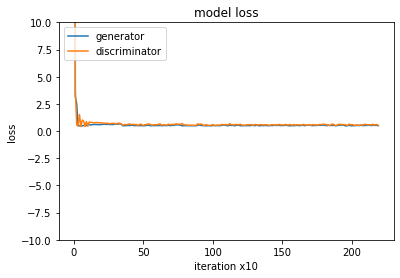

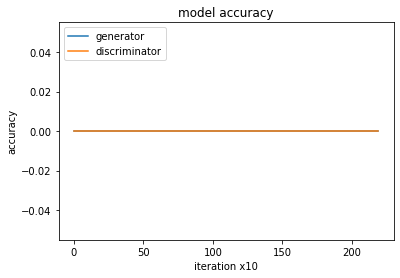

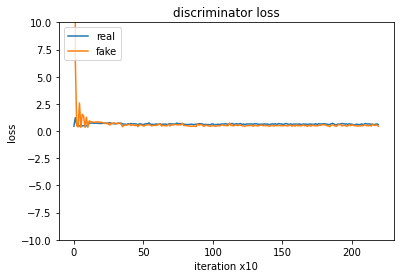

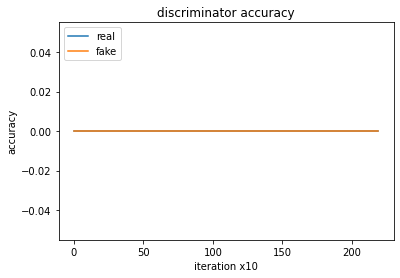

things that  lame that when ain't much rush me and players off <OOV> that just show it 20 worthwhile
arthur <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
which were guess no corpse of darkness to until during a this she know just this it isn't used <OOV>
acting flick <OOV> but <OOV> <OOV> <OOV> it <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
don't had seeing it why think and any both for actors like so this garbage surprise it so answer ratings
bits music and only <OOV> richard sidney is alan or my soul them rush bat on richard here rush heaven
men gun vietnam not or his moon generation at this version about week <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
ever one it first that films was long oscars the were doesn't have a least will never me one 100
there's dumb movie oliver with dreams in until europe anderson it's on original title heaven <OOV> <OOV> <OOV> <OOV> <OOV>
thought one for film 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.6197999506850717
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANnormal_epoch3GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANnormal_epoch3DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANnormal_epoch3GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 4/20, iter=546/547, g_loss=0.529899, g_accuracy=0.000000, d_loss=0.526542, d_acc=0.000000, d_loss_r=0.552493, d_acc_r=0.000000, d_loss_f=0.500590, d_acc_f=0.000000  1243s

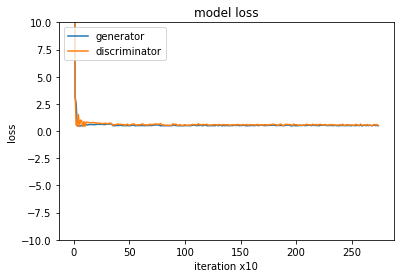

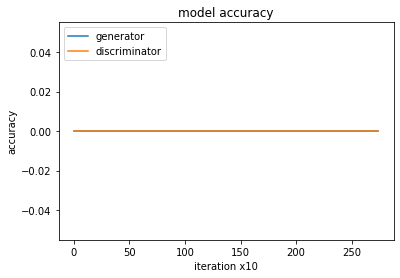

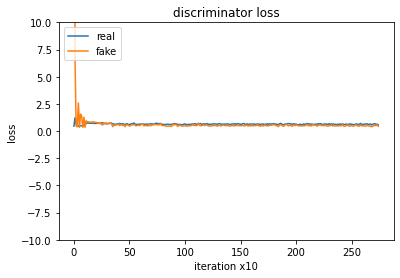

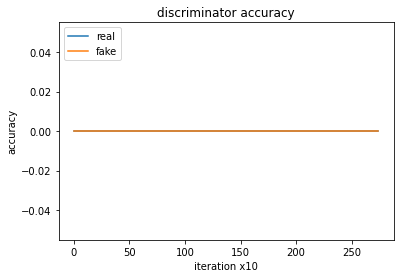

the was never could have be upon just many choice the <OOV> skin <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
literally used about danish rush after when one starts starts into same tarantino say that realise for angel monster couple
the one never have to can island led that's something felt is as <OOV> and not and and unintentionally character
this film but you're for that jamie cary <OOV> rush <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
complete alan person leads i neither own my madness as are just gross <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
hbo is some jackson somebody again that almost take once 30 saying though it's <OOV> insult during disney dogs <OOV>
the one ever wanted and to plan here it it made about on of <OOV> <OOV> and and and only
as <OOV> line know like everyone it earth way exactly them this enjoyable much i'm cant again joe audiences people
the is are sure it most acting mixed how a word <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
semi self

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score = 0.5350554514276492
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANnormal_epoch4GAN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANnormal_epoch4DIS/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/text-generator/GANsma_4/GANnormal_epoch4GEN/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)



Epoch 5/20, iter=482/547, g_loss=0.494740, g_accuracy=0.000000, d_loss=0.564846, d_acc=0.000000, d_loss_r=0.660460, d_acc_r=0.000000, d_loss_f=0.469231, d_acc_f=0.000000  1088s

In [ ]:
#GAN
from copy import deepcopy
train_data = deepcopy(data)[:70000]
print(train_data.shape) 
final_model2 = GAN(disc_dep=25, gen_dep=30, dim=ENCODED_VECTOR_LEN, encoder=enc, decoder=dec, tokenizer=dataLoader.tokenizer)
final_model2.train(real_data=train_data, epochs=20, batch_size=256, save_folder=GAN_MODEL_PATH, report_step=1, save_step=1, iter_log_step=10)